# Support Vector Machines
using the [Titanic dataset](https://www.kaggle.com/c/titanic/data).

Based on an [example notebook by Dr. Eric Larson](https://github.com/eclarson/DataMiningNotebooks/blob/master/04.%20Logits%20and%20SVM.ipynb).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
df = pd.read_csv('data/titanic.csv')

### Data preprocessing

In [3]:
# Remove identifiers and other attributes that aren't useful
del df['PassengerId']
del df['Name']
del df['Cabin']
del df['Ticket']

In [4]:
# Impute missing values

# Group by passenger class and family size (# siblings and spouses)
df_grouped = df.groupby(by=['Pclass','SibSp'])

# fill in the numeric values
df_imputed = df_grouped.transform(lambda grp: grp.fillna(grp.median()))

# fill in the categorical values
df_imputed[['Sex','Embarked']] = df_grouped[['Sex','Embarked']].apply(lambda grp: grp.fillna(grp.mode()))

# fillin the grouped variables from original data frame
df_imputed[['Pclass','SibSp']] = df[['Pclass','SibSp']]

# 3. Computed discrete features agains now with the newest values
df_imputed['age_range'] = pd.cut(df_imputed.Age,[0,16,24,65,1e6],4,labels=[0,1,2,3]) # this creates a new variable

# 4. drop rows that still had missing values after grouped imputation
df_imputed.dropna(inplace=True)
df_imputed.age_range = df_imputed.age_range.astype(np.int)

# 5. Rearrange the columns
df_imputed = df_imputed[['Survived','Age','age_range','Sex','Parch','SibSp','Pclass','Fare','Embarked']]

In [5]:
# One-hot encode the categorical attribute "Embarked"
tmp_df = pd.get_dummies(df_imputed.Embarked, prefix='Embarked')
df_imputed = pd.concat((df_imputed, tmp_df), axis=1) # append to the imputed dataframe

# replace Sex atribute with IsMale
df_imputed['IsMale'] = df_imputed.Sex=='male' 
df_imputed.IsMale = df_imputed.IsMale.astype(np.int)

# Remove the original attributes
del df_imputed['Embarked']
del df_imputed['Sex']

In [6]:
# Create a new variable based on the number of family members traveling with the passenger
df_imputed['FamilySize'] = df_imputed.Parch + df_imputed.SibSp

In [7]:
df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 882 entries, 0 to 890
Data columns (total 12 columns):
Survived      882 non-null int64
Age           882 non-null float64
age_range     882 non-null int64
Parch         882 non-null int64
SibSp         882 non-null int64
Pclass        882 non-null int64
Fare          882 non-null float64
Embarked_C    882 non-null uint8
Embarked_Q    882 non-null uint8
Embarked_S    882 non-null uint8
IsMale        882 non-null int64
FamilySize    882 non-null int64
dtypes: float64(2), int64(7), uint8(3)
memory usage: 71.5 KB


### Prepare data for classification tasks

In [8]:
X = df_imputed.iloc[:,1:].values
y = df_imputed.iloc[:,0].values

In [9]:
# Create a cross-validation object
splitter = ShuffleSplit(n_splits=5, test_size=0.2)

# Create a scaling object
scaler = StandardScaler()

In [10]:
for train_indices, test_indices in splitter.split(X,y): 
    # Sample the training set
    X_train = X[train_indices]
    y_train = y[train_indices]

    # Sample the test set
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    # Scale the training and test sets independently
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.fit_transform(X_test)
    
    # train a (non-linear) support vector machine
    svm_clf = SVC()
    svm_clf.fit(X_train_scaled, y_train)
    
    # make predictions on the test set
    y_hat = svm_clf.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_hat)
    conf = confusion_matrix(y_test, y_hat)
    
    print('Accuracy: {:.3f}'.format(acc))
    print('Confusion matrix:\n', conf)

Accuracy: 0.819
Confusion matrix:
 [[92 15]
 [17 53]]
Accuracy: 0.797
Confusion matrix:
 [[93 16]
 [20 48]]
Accuracy: 0.819
Confusion matrix:
 [[97 11]
 [21 48]]
Accuracy: 0.785
Confusion matrix:
 [[87 15]
 [23 52]]
Accuracy: 0.825
Confusion matrix:
 [[90  5]
 [26 56]]


In [11]:
# look at the support vectors
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

(335, 11)
(335,)
[172 163]


### Examine the support vectors

In [12]:
# training data from the last iteration
df_tested_on = df_imputed.iloc[train_indices,:]

# support vectors from the last trained model
df_support = df_tested_on.iloc[svm_clf.support_,:]

# add back the 'Survived' Column
df_support['Survived'] = y[svm_clf.support_]

# also add it back in for the original data
df_imputed['Survived'] = y

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [13]:
# group the original data and the support vectors
df_grouped_support = df_support.groupby(['Survived'])
df_grouped = df_imputed.groupby(['Survived'])

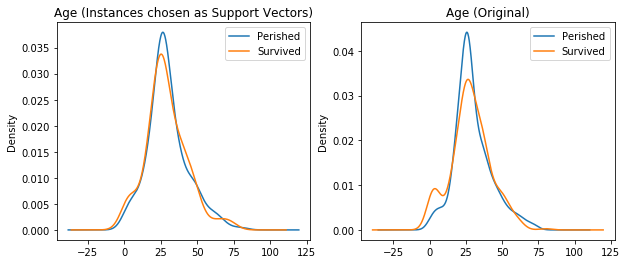

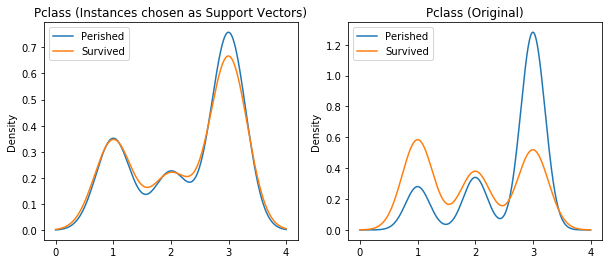

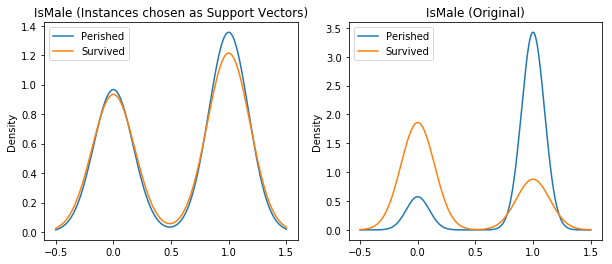

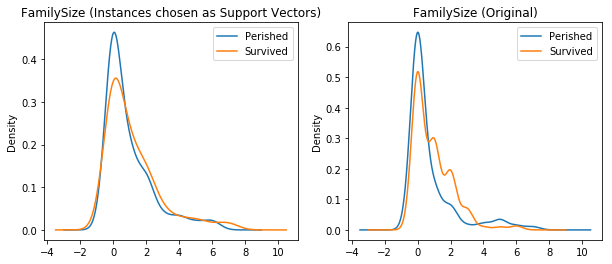

In [14]:
# plot KDE of Different variables
vars_to_plot = ['Age','Pclass','IsMale','FamilySize']

for v in vars_to_plot:
    plt.figure(figsize=(10,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['Perished','Survived'])
    plt.title(v+' (Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['Perished','Survived'])
    plt.title(v+' (Original)')